# RESUMEN

    Se va a usar un modelo de Transformer NN (T5) preentrenado para la clasificacion en un contexto de NLP. Este codigo esta basado en el el ejemplo provisto aca:
    https://github.com/patil-suraj/exploring-T5/blob/master/t5_fine_tuning.ipynb

# Imports y settings

In [ ]:
!nvidia-smi

Sat Aug  1 13:19:55 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install transformers
!pip install pytorch_lightning

     |████████████████████████████████| 778kB 8.4MB/s 
     |████████████████████████████████| 3.0MB 24.1MB/s 
     |████████████████████████████████| 890kB 54.9MB/s 
     |████████████████████████████████| 1.1MB 49.3MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=72012f0a6bf0bbbcb72ec0f71da78f0e7bb55fa5b832f862d31d565e7ad1db70
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 317kB 7.6MB/s 
     |████████████████████████████████| 276kB 4.0MB/s 
     |████████████████████████████████| 829kB 17.0MB/s 
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp36-cp36m-linux_x86_64.whl size=44621 sha256=55ed7338647ccab9937adf5231a76d42e0c1141cca4b45bc4e16979e2aee2c2f
  Stored in directory: /root/.cache/pip/wheels/a7/c1/ea/cf5bd31012e735dc1dfea3131a2d5eae7978b251083d6247bd
  Created wheel for future: filename=future-0

In [ ]:
# Imports
import argparse
import glob
import os
import json
import time
import logging
import random
import re
from itertools import chain
from string import punctuation
import pandas as pd

import textwrap
from tqdm.auto import tqdm

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from sklearn.model_selection import train_test_split
from sklearn import metrics
import seaborn as sns

import matplotlib.pyplot as plt
from matplotlib import rc


from transformers import (
    AdamW,
    T5ForConditionalGeneration,
    T5Tokenizer,
    get_linear_schedule_with_warmup
)

#Settings
def set_seed(seed):
  random.seed(seed)
  np.random.seed(seed)
  torch.manual_seed(seed)
  if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

set_seed(42)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
to_predict = pd.read_csv('clean_test.csv').fillna(' ')
to_predict['complete_text'] = to_predict['keyword'] + ' ' + to_predict['location'] + ' ' + to_predict['text']
len(to_predict)

3263

3271 4342


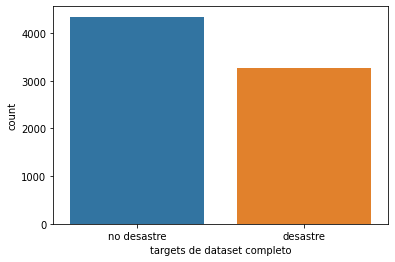

In [ ]:
data = pd.read_csv('clean_train.csv').fillna(' ')
data['complete_text'] = data['keyword'] + ' ' + data['location'] + ' ' + data['text']

tag_1 = data[data['target'] == 1]
tag_0 = data[data['target'] == 0]


ax = sns.countplot(data.target)
plt.xlabel('targets de dataset completo')
ax.set_xticklabels(['no desastre','desastre']);
print(len(tag_1),len(tag_0))

In [ ]:
#Esto es para que el set de train y val este equilibrado entre 1 y 0 y para que el 
#set de validacion tenga solo datos nuevos que no se usaron en train 

tag_1_val_size = 0.1

tag_0_val_size = 1 - (len(tag_1) * (1 - tag_1_val_size))/(len(tag_0))

tag_1_train, tag_1_val = train_test_split(tag_1, test_size = tag_1_val_size)
tag_0_train, tag_0_val = train_test_split(tag_0, test_size = tag_0_val_size)

tag_0_val = tag_0_val.sample(len(tag_1_val))

train = pd.concat([tag_1_train,tag_0_train])
val = pd.concat([tag_1_val,tag_0_val])
len(train),len(val)

(5886, 656)

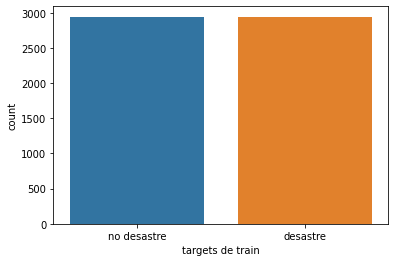

In [ ]:
ax = sns.countplot(train.target)
plt.xlabel('targets de train')
ax.set_xticklabels(['no desastre','desastre']);


[Text(0, 0, 'no desastre'), Text(0, 0, 'desastre')]

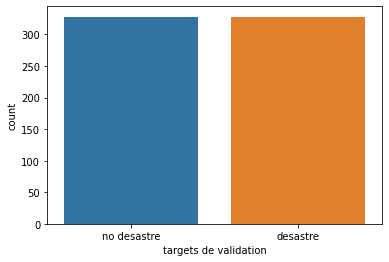

In [ ]:
ax = sns.countplot(val.target)
plt.xlabel('targets de validation')
ax.set_xticklabels(['no desastre','desastre'])

# Definicion de clases wrappers

In [ ]:
class T5FineTuner(pl.LightningModule):
    def __init__(self, hparams, data):
        super(T5FineTuner, self).__init__()
        self.hparams = hparams
        self.data = data
        self.model = T5ForConditionalGeneration.from_pretrained(hparams.model_name_or_path)
        self.tokenizer = T5Tokenizer.from_pretrained(hparams.tokenizer_name_or_path)

    def is_logger(self):
        return self.trainer.proc_rank <= 0

    def forward(
          self, input_ids, attention_mask=None, decoder_input_ids=None, decoder_attention_mask=None, lm_labels=None
        ):
        return self.model(
            input_ids,
            attention_mask=attention_mask,
            decoder_input_ids=decoder_input_ids,
            decoder_attention_mask=decoder_attention_mask,
            lm_labels=lm_labels,
        )

    def _step(self, batch):
        lm_labels = batch["target_ids"]
        lm_labels[lm_labels[:, :] == self.tokenizer.pad_token_id] = -100

        outputs = self(
            input_ids=batch["source_ids"],
            attention_mask=batch["source_mask"],
            lm_labels=lm_labels,
            decoder_attention_mask=batch['target_mask']
        )

        loss = outputs[0]

        return loss

    def training_step(self, batch, batch_idx):
        loss = self._step(batch)

        tensorboard_logs = {"train_loss": loss}
        return {"loss": loss, "log": tensorboard_logs}

    def training_epoch_end(self, outputs):
        avg_train_loss = torch.stack([x["loss"] for x in outputs]).mean()
        tensorboard_logs = {"avg_train_loss": avg_train_loss}
        return {"avg_train_loss": avg_train_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def validation_step(self, batch, batch_idx):
        loss = self._step(batch)
        return {"val_loss": loss}

    def validation_epoch_end(self, outputs):
        avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
        tensorboard_logs = {"val_loss": avg_loss}
        return {"avg_val_loss": avg_loss, "log": tensorboard_logs, 'progress_bar': tensorboard_logs}

    def configure_optimizers(self):
        "Prepare optimizer and schedule (linear warmup and decay)"

        model = self.model
        no_decay = ["bias", "LayerNorm.weight"]
        optimizer_grouped_parameters = [
            {
                "params": [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)],
                "weight_decay": self.hparams.weight_decay,
            },
            {
                "params": [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)],
                "weight_decay": 0.0,
            },
        ]
        optimizer = AdamW(optimizer_grouped_parameters, lr=self.hparams.learning_rate, eps=self.hparams.adam_epsilon)
        self.opt = optimizer
        return [optimizer]

    def optimizer_step(self, epoch, batch_idx, optimizer, optimizer_idx, second_order_closure=None, using_native_amp = None ):
        if self.trainer.use_tpu:
          xm.optimizer_step(optimizer)
        else:
          optimizer.step()
        optimizer.zero_grad()
        self.lr_scheduler.step()

    def get_tqdm_dict(self):
        tqdm_dict = {"loss": "{:.3f}".format(self.trainer.avg_loss), "lr": self.lr_scheduler.get_last_lr()[-1]}

        return tqdm_dict

    def train_dataloader(self):
        train_dataset = get_dataset(tokenizer=self.tokenizer,data = self.data, args=self.hparams)
        dataloader = DataLoader(train_dataset, batch_size=self.hparams.train_batch_size, drop_last=True, shuffle=True, num_workers=4)
        t_total = (
            (len(dataloader.dataset) // (self.hparams.train_batch_size * max(1, self.hparams.n_gpu)))
            // self.hparams.gradient_accumulation_steps
            * float(self.hparams.num_train_epochs)
        )
        scheduler = get_linear_schedule_with_warmup(
            self.opt, num_warmup_steps=self.hparams.warmup_steps, num_training_steps=t_total
        )
        self.lr_scheduler = scheduler
        return dataloader

    def val_dataloader(self):
        val_dataset = get_dataset(tokenizer=self.tokenizer,data = self.data , args=self.hparams)
        return DataLoader(val_dataset, batch_size=self.hparams.eval_batch_size, num_workers=4)
    
logger = logging.getLogger(__name__)
    
class LoggingCallback(pl.Callback):
    def on_validation_end(self, trainer, pl_module):
        logger.info("***** Validation results *****")
        if pl_module.is_logger():
          metrics = trainer.callback_metrics
          # Log results
          for key in sorted(metrics):
            if key not in ["log", "progress_bar"]:
              logger.info("{} = {}\n".format(key, str(metrics[key])))

    def on_test_end(self, trainer, pl_module):
        logger.info("***** Test results *****")

        if pl_module.is_logger():
          metrics = trainer.callback_metrics

          # Log and save results to file
          output_test_results_file = os.path.join(pl_module.hparams.output_dir, "test_results.txt")
          with open(output_test_results_file, "w") as writer:
            for key in sorted(metrics):
              if key not in ["log", "progress_bar"]:
                logger.info("{} = {}\n".format(key, str(metrics[key])))
                writer.write("{} = {}\n".format(key, str(metrics[key])))

# Eleccion de hiperparamentros e inicializacion

In [ ]:
#Eleccion de hiperparamentros
args_dict = dict(
    output_dir= "", # path to save the checkpoints
    model_name_or_path='t5-base',
    tokenizer_name_or_path='t5-base',
    max_seq_length= max(train.complete_text.apply(len)),
    learning_rate=2e-5,
    weight_decay=0.00,
    adam_epsilon=1e-8,
    warmup_steps=1,
    train_batch_size=8,
    eval_batch_size=8,
    num_train_epochs=2,
    gradient_accumulation_steps=15,
    n_gpu=1,
    early_stop_callback=False,
    fp_16=False, # if you want to enable 16-bit training then install apex and set this to true
    opt_level='O1', # you can find out more on optimisation levels here https://nvidia.github.io/apex/amp.html#opt-levels-and-properties
    max_grad_norm=1.0, # if you enable 16-bit training then set this to a sensible value, 0.5 is a good default
    seed=42,
)

args_dict.update({'output_dir': 'T5_train', 'num_train_epochs':2})
args = argparse.Namespace(**args_dict)

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filepath=args.output_dir, prefix="checkpoint", monitor="val_loss", mode="min", save_top_k=5
)

train_params = dict(
    accumulate_grad_batches=args.gradient_accumulation_steps,
    gpus=args.n_gpu,
    max_epochs=args.num_train_epochs,
    early_stop_callback=False,
    precision= 16 if args.fp_16 else 32,
    amp_level=args.opt_level,
    gradient_clip_val=args.max_grad_norm,
    checkpoint_callback=checkpoint_callback,
    callbacks=[LoggingCallback()],
)

# Inicializacion
tokenizer = T5Tokenizer.from_pretrained('t5-base')

model = T5FineTuner(args,train)

trainer = pl.Trainer(**train_params)


Some weights of T5ForConditionalGeneration were not initialized from the model checkpoint at t5-base and are newly initialized: ['encoder.embed_tokens.weight', 'decoder.embed_tokens.weight', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


# Preprocesamiento

In [ ]:
class TweetsDataset(Dataset):
  def __init__(self, data, tokenizer, max_len=512, labels = True):
    
    self.max_len = max_len
    self.tokenizer = tokenizer
    self.inputs = []
    self.targets = []
    self.labels = labels

    self._build(data)
  
  def __len__(self):
    return len(self.inputs)
  
  def __getitem__(self, index):
    source_ids = self.inputs[index]["input_ids"].squeeze()
    src_mask    = self.inputs[index]["attention_mask"].squeeze()  # might need to squeeze

    if self.labels:
      target_ids = self.targets[index]["input_ids"].squeeze()
      target_mask = self.targets[index]["attention_mask"].squeeze()  # might need to squeeze
      return {"source_ids": source_ids, "source_mask": src_mask, "target_ids": target_ids, "target_mask": target_mask}
    else:
      return {"source_ids": source_ids, "source_mask": src_mask}
  
  def _build(self,data):

    for index, row in data.iterrows():

      line = row['complete_text']
      line = line + ' </s>'

      # tokenize inputs
      tokenized_inputs = self.tokenizer.batch_encode_plus(
          [line], max_length=self.max_len, pad_to_max_length=True, return_tensors="pt", truncation=True
      )

      self.inputs.append(tokenized_inputs)

      try:
        target = str(row['target'])
        target = target + " </s>"

        # tokenize targets
        tokenized_targets = self.tokenizer.batch_encode_plus(
            [target], max_length=2, pad_to_max_length=True, return_tensors="pt", truncation=True
        )
        self.targets.append(tokenized_targets)
      except:
        pass


def get_dataset(tokenizer, data, args):
  return TweetsDataset(tokenizer=tokenizer,data = data, max_len=args.max_seq_length)


# Entrenamiento

In [ ]:
# Entrenamiento
trainer.fit(model)


  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 


1

# Validacion

In [ ]:
def correctOutput(out):
  for i,o in enumerate(out):
    if o == '':
      out[i] = '0'
  return out

def mapLabelsToNumeric(out):
  for i,o in enumerate(out):
    if o.isnumeric():
      out[i] = int(o)
    else:
      out[i] = 1
  return out

In [ ]:
# Validacion

dataset = TweetsDataset(val,tokenizer)
loader = DataLoader(dataset, batch_size=128, num_workers=8)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'], 
                              attention_mask=batch['source_mask'], 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

outputs = correctOutput(outputs)
outputs = mapLabelsToNumeric(outputs)
targets = mapLabelsToNumeric(targets)

print(metrics.classification_report(targets, outputs))
print(metrics.f1_score(targets, outputs))


              precision    recall  f1-score   support

           0       0.61      0.51      0.56       328
           1       0.58      0.66      0.61       328
           2       0.00      0.00      0.00         0
          11       0.00      0.00      0.00         0
          15       0.00      0.00      0.00         0

    accuracy                           0.59       656
   macro avg       0.24      0.23      0.23       656
weighted avg       0.59      0.59      0.59       656



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


ValueError: ignored

In [ ]:
set(train.target)

{0, 1}

In [ ]:
44444cffffffffff

In [ ]:
sns.countplot(outputs)

# Predecir

In [ ]:
# predecir

dataset = TweetsDataset(to_predict,tokenizer, labels = False)
loader = DataLoader(dataset, batch_size=32, num_workers=8)
model.model.eval()
outputs = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'], 
                              attention_mask=batch['source_mask'], 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  outputs.extend(dec)

In [ ]:
vvbvbvbvbvdfdfffcvcvcvcdddd

In [ ]:
outputs = correctOutput(outputs)
predicted_target = mapLabelsToNumeric(outputs)
to_predict['target'] = predicted_target
submit = to_predict[['id','target']].set_index('id')
submit

,target
id,
0,0
2,0
3,1
9,0
11,0
...,...
10861,0
10865,0
10868,1


In [ ]:
submit.target = submit.target.apply(lambda x: 1 if x > 1 else x)

In [ ]:
VERSION = 5

In [ ]:
submit.to_csv('T5_submit_' + str(VERSION) + '.csv')

In [ ]:
submit.to_csv('submission.csv')
!kaggle competitions submit -c nlp-getting-started -f submission.csv -m "neural net T5"

100% 22.2k/22.2k [00:00<00:00, 105kB/s]
Successfully submitted to Real or Not? NLP with Disaster Tweets

# Generar prediccion sobre train para usar como feature

In [ ]:
# feature sobre train

dataset = TweetsDataset(data,tokenizer)
loader = DataLoader(dataset, batch_size=32, num_workers=8)
model.model.eval()
outputs = []
targets = []
for batch in tqdm(loader):
  outs = model.model.generate(input_ids=batch['source_ids'], 
                              attention_mask=batch['source_mask'], 
                              max_length=2)

  dec = [tokenizer.decode(ids) for ids in outs]
  target = [tokenizer.decode(ids) for ids in batch["target_ids"]]
  
  outputs.extend(dec)
  targets.extend(target)

In [ ]:
outputs = correctOutput(outputs)
fe_train = mapLabelsToNumeric(outputs)
targets = mapLabelsToNumeric(targets)
print(metrics.classification_report(targets, fe_train))
print(metrics.f1_score(targets, fe_train))
data['T5_prediction'] = fe_train
fe_T5 = data[['id','T5_prediction']].set_index('id')
fe_T5.to_csv('T5_fe_' + str(VERSION) + '.csv')